# Iteration test
This file demonstrates how to initialize an Equilibrium object from leading order quantities and tests its accuracy.

In [6]:
# This file implements and tests recursion relations
from matplotlib import pyplot as plt

# for importing parsed codes
import sys
import cProfile
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/MHD_parsed/')
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/')
debug_path = '/Users/lanke/Desktop/Second year project/Code/test_data_eduardo/'
from chiphifunc import *
from math_utilities import *
from chiphiepsfunc import *
from chiphifunc_test_suite import *
from equilibrium import *
# Checking if file exists
from pathlib import Path


import MHD_parsed

ModuleNotFoundError: No module named 'chiphifunc'

Configuration has 1.0 field periods.
Axis shape:


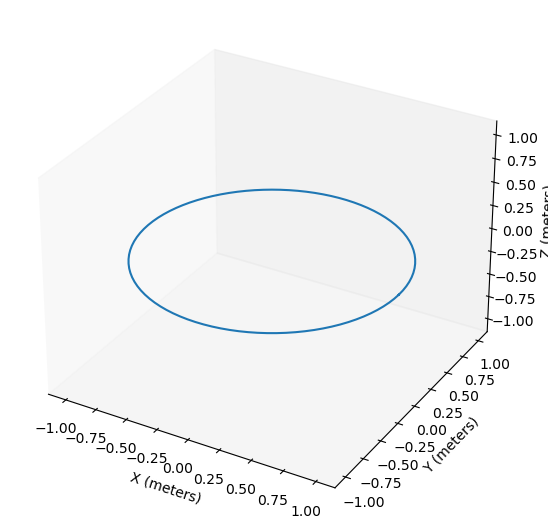

In [5]:
# No B theta
B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'circ/', 
        R_array=[2,0,1,2,0.0001,0],
        Z_array=[1,2,0,0.001]
    )

## Initializing an `Equilibrium`
### Required quantities and orders
Unknowns:

1. X_coef_cp: 2
2. Y_coef_cp: 2
3. Z_coef_cp: 2
4. B_psi_coef_cp: 0
5. B_theta_coef_cp: 2
6. iota_coef: 0
7. Delta_coef_cp: 3
8. p_perp_coef_cp: 3

Known constants:
1. B_denom_coef_c: 2
2. B_alpha_coef: 1
3. kap_p
4. dl_p 
5. tau_p
6. eta

In [6]:
equilibrium = Equilibrium.from_known(
    X_coef_cp=X_coef_cp.mask(2),
    Y_coef_cp=Y_coef_cp.mask(2),
    Z_coef_cp=Z_coef_cp.mask(2),
    B_psi_coef_cp=B_psi_coef_cp.mask(0),
    B_theta_coef_cp=B_theta_coef_cp.mask(2),
    B_denom_coef_c=B_denom_coef_c.mask(2),
    B_alpha_coef=B_alpha_coef.mask(1),
    iota_coef=iota_coef.mask(0), 
    kap_p=kap_p, 
    dl_p=dl_p, 
    tau_p=tau_p,
    eta=eta,
    p_perp_coef_cp = p_perp_coef_cp.mask(2), 
    Delta_coef_cp = Delta_coef_cp.mask(2))

In [1]:
# Plot all 7 governing equations' deviation from equality together
# in log scale.
def plot_all_errors(
    J_list, 
    Cb_list, Ck_list, Ct_list, 
    I_list, II_list, III_list, 
    X_list, Y_list, Z_list, 
    B_psi_list, B_theta_list, 
    p_perp_list, delta_list):
    print('For J, minimum deviation from equality occurs at max_freq:',param_list[np.argmin(np.array(J_list))])
    plt.plot(param_list, np.array(J_list), label='J')
    print('For Cb, minimum deviation from equality occurs at max_freq:',param_list[np.argmin(np.array(Cb_list))])
    plt.plot(param_list, np.array(Cb_list), label='Cb') # 3rd order equation
    print('For Ck, minimum deviation from equality occurs at max_freq:',param_list[np.argmin(np.array(Ck_list))])
    plt.plot(param_list, np.array(Ck_list), label='Ck') # 3rd order equation
    print('For Ct, minimum deviation from equality occurs at max_freq:',param_list[np.argmin(np.array(Ct_list))])
    plt.plot(param_list, np.array(Ct_list), label='Ct') # 3rd order equation
    print('For I, minimum deviation from equality occurs at max_freq:',param_list[np.argmin(np.array(I_list))])
    plt.plot(param_list, I_list, label='I') 
    print('For II, minimum deviation from equality occurs at max_freq:',param_list[np.argmin(np.array(II_list))])
    plt.plot(param_list, II_list, label='II')
    print('For III, minimum deviation from equality occurs at max_freq:',param_list[np.argmin(np.array(III_list))])
    plt.plot(param_list, III_list, label='III')
    
    # Plotting amplitudes
    plt.plot(param_list, X_list, color='grey', linestyle='dashed')
    plt.plot(param_list, Y_list, color='grey', linestyle='dashed')
    plt.plot(param_list, Z_list, color='grey', linestyle='dashed')
    plt.plot(param_list, B_psi_list, color='grey', linestyle='dashed')
    plt.plot(param_list, B_theta_list, color='grey', linestyle='dashed')
    plt.plot(param_list, p_perp_list, color='grey', linestyle='dashed')
    plt.plot(param_list, delta_list, color='grey', linestyle='dashed')
    
    plt.xlabel('# mode numbers')
    plt.ylabel('Deviation from equality')
    plt.yscale('log')
    plt.grid()
    plt.legend()
    print(
        'The product of their deviation from equality is minimized at max_freq:',
        param_list[np.argmin(np.array(
            np.prod(np.array([J_list,Cb_list,Ck_list,Ct_list,I_list,II_list,III_list]), axis=0)
        ))]
    )

In [2]:
list(range(4,10))

[4, 5, 6, 7, 8, 9]

In [3]:
# Tries different iteration phi frequency limits until end_order.
# init_equilibrium: a 2nd order equilibium
# end_order: 
# Output: -----
# order_list [4, 5, ..., end_order]
def regularity_trial(init_equilbrium, end_order, param_list=list(range(10,100))):
    if end_order<4:
        raise ValueError('end_order need to be > 4.')
    end_order-=end_order%2
    print('iterating till order', end_order)
    order = 4
    optimum_max_freq = []
    order_list = []
    order_quants_list = []
    while order<end_order:
        order_dict = {}
        order_dict['J_list']=[]
        order_dict['Cb_list']=[]
        order_dict['Ck_list']=[]
        order_dict['Ct_list']=[]
        order_dict['I_list']=[]
        order_dict['II_list']=[]
        order_dict['III_list']=[]
        order_dict['time_list']=[]
        order_dict['X_list']=[]
        order_dict['Y_list']=[]
        order_dict['Z_list']=[]
        order_dict['B_psi_list']=[]
        order_dict['B_theta_list']=[]
        order_dict['p_perp_list']=[]
        order_dict['delta_list']=[]
        for i in param_list:
            path_i = Path('harmonic_number/save_test_'+str(i)+'.npz')
            start_time = time.time()
            if path_i.is_file():
                equilibrium = Equilibrium.load(path_i)
            else:
                equilibrium.iterate_2(
                    n_eval=4,
                    B_alpha_nb2=0,
                    B_denom_nm1=B_denom_coef_c[3], B_denom_n=0,
                    iota_new=iota_coef[1],
                    loop_max_freq=(i,10)
                )
                equilibrium.save(path_i)
            X_coef_cp = equilibrium.unknown['X_coef_cp']
            Y_coef_cp = equilibrium.unknown['Y_coef_cp']
            Z_coef_cp = equilibrium.unknown['Z_coef_cp']
            B_theta_coef_cp = equilibrium.unknown['B_theta_coef_cp']
            B_psi_coef_cp = equilibrium.unknown['B_psi_coef_cp']
            iota_coef = equilibrium.unknown['iota_coef']
            p_perp_coef_cp = equilibrium.unknown['p_perp_coef_cp']
            Delta_coef_cp = equilibrium.unknown['Delta_coef_cp']
            B_denom_coef_c = equilibrium.constant['B_denom_coef_c']
            B_alpha_coef = equilibrium.constant['B_alpha_coef']
            kap_p = equilibrium.constant['kap_p']
            dl_p = equilibrium.constant['dl_p']
            tau_p = equilibrium.constant['tau_p']
            eta = equilibrium.constant['eta']

            (J, Cb, Ck, Ct, I, II, III) = equilibrium.check_governing_equations(3)
            J_list.append(np.average(np.abs(J.content)))
            Cb_list.append(np.average(np.abs(Cb.content)))
            Ck_list.append(np.average(np.abs(Ck.content)))
            Ct_list.append(np.average(np.abs(Ct.content)))
            I_list.append(np.average(np.abs(I.content)))
            II_list.append(np.average(np.abs(II.content)))
            III_list.append(np.average(np.abs(III.content)))
            time_list.append(time.time() - start_time)


## Accuracy with different maximum frequency considered in ODE solve

In [4]:
param_list = list(range(10,100))
write = True
J_list=[]
Cb_list=[]
Ck_list=[]
Ct_list=[]
I_list=[]
II_list=[]
III_list=[]
time_list=[]
for i in param_list:
    path_i = Path('harmonic_number/save_test_'+str(i)+'.npz')
    start_time = time.time()
    if path_i.is_file():
        equilibrium = Equilibrium.load(path_i)
    else:
        equilibrium.iterate_2(
            n_eval=4,
            B_alpha_nb2=0,
            B_denom_nm1=B_denom_coef_c[3], B_denom_n=0,
            iota_new=iota_coef[1],
            loop_max_freq=(i,10)
        )
        equilibrium.save(path_i)
    X_coef_cp = equilibrium.unknown['X_coef_cp']
    Y_coef_cp = equilibrium.unknown['Y_coef_cp']
    Z_coef_cp = equilibrium.unknown['Z_coef_cp']
    B_theta_coef_cp = equilibrium.unknown['B_theta_coef_cp']
    B_psi_coef_cp = equilibrium.unknown['B_psi_coef_cp']
    iota_coef = equilibrium.unknown['iota_coef']
    p_perp_coef_cp = equilibrium.unknown['p_perp_coef_cp']
    Delta_coef_cp = equilibrium.unknown['Delta_coef_cp']
    B_denom_coef_c = equilibrium.constant['B_denom_coef_c']
    B_alpha_coef = equilibrium.constant['B_alpha_coef']
    kap_p = equilibrium.constant['kap_p']
    dl_p = equilibrium.constant['dl_p']
    tau_p = equilibrium.constant['tau_p']
    eta = equilibrium.constant['eta']
    
    (J, Cb, Ck, Ct, I, II, III) = equilibrium.check_governing_equations(3)
    J_list.append(np.average(np.abs(J.content)))
    Cb_list.append(np.average(np.abs(Cb.content)))
    Ck_list.append(np.average(np.abs(Ck.content)))
    Ct_list.append(np.average(np.abs(Ct.content)))
    I_list.append(np.average(np.abs(I.content)))
    II_list.append(np.average(np.abs(II.content)))
    III_list.append(np.average(np.abs(III.content)))
    time_list.append(time.time() - start_time)


NameError: name 'Path' is not defined

For J, minimum deviation from equality occurs at max_freq: 96
For Cb, minimum deviation from equality occurs at max_freq: 16
For Ck, minimum deviation from equality occurs at max_freq: 15
For Ct, minimum deviation from equality occurs at max_freq: 96
For I, minimum deviation from equality occurs at max_freq: 12
For II, minimum deviation from equality occurs at max_freq: 13
For III, minimum deviation from equality occurs at max_freq: 15
The product of their deviation from equality is minimized at max_freq: 15


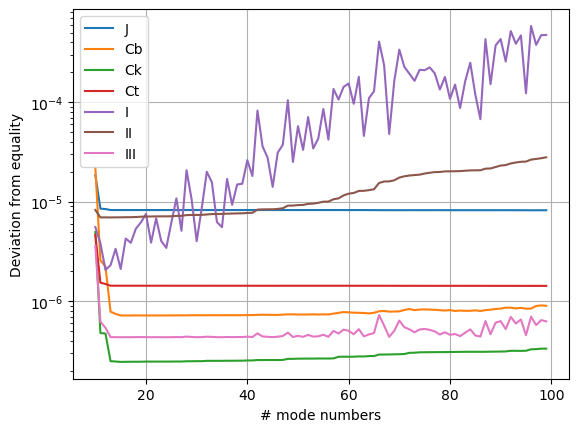

In [36]:
plot_all_errors(J_list, Cb_list, Ck_list, Ct_list, I_list, II_list, III_list)

In [37]:
param_list = list(range(10,100))
write = True
J_list=[]
Cb_list=[]
Ck_list=[]
Ct_list=[]
I_list=[]
II_list=[]
III_list=[]
time_list=[]
for i in param_list:
    start_time=time.time()
    path_i = Path('harmonic_number_4/save_test_'+str(i)+'.npz')
    if path_i.is_file():
        equilibrium = Equilibrium.load(path_i)
    else:
        equilibrium.iterate_2(
            n_eval=4,
            B_alpha_nb2=0,
            B_denom_nm1=B_denom_coef_c[3], B_denom_n=0,
            iota_new=iota_coef[1],
            loop_max_freq=(15,i)
        )
        equilibrium.save(path_i)
    X_coef_cp = equilibrium.unknown['X_coef_cp']
    Y_coef_cp = equilibrium.unknown['Y_coef_cp']
    Z_coef_cp = equilibrium.unknown['Z_coef_cp']
    B_theta_coef_cp = equilibrium.unknown['B_theta_coef_cp']
    B_psi_coef_cp = equilibrium.unknown['B_psi_coef_cp']
    iota_coef = equilibrium.unknown['iota_coef']
    p_perp_coef_cp = equilibrium.unknown['p_perp_coef_cp']
    Delta_coef_cp = equilibrium.unknown['Delta_coef_cp']
    B_denom_coef_c = equilibrium.constant['B_denom_coef_c']
    B_alpha_coef = equilibrium.constant['B_alpha_coef']
    kap_p = equilibrium.constant['kap_p']
    dl_p = equilibrium.constant['dl_p']
    tau_p = equilibrium.constant['tau_p']
    eta = equilibrium.constant['eta']
    
    (J, Cb, Ck, Ct, I, II, III) = equilibrium.check_governing_equations(4)
    J_list.append(np.average(np.abs(J.content)))
    Cb_list.append(np.average(np.abs(Cb.content)))
    Ck_list.append(np.average(np.abs(Ck.content)))
    Ct_list.append(np.average(np.abs(Ct.content)))
    I_list.append(np.average(np.abs(I.content)))
    II_list.append(np.average(np.abs(II.content)))
    III_list.append(np.average(np.abs(III.content)))
    time_list.append(time.time() - start_time)


Evaluating order 3 4
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
Time elapsed(s): 4.440769910812378
Evaluating order 3 4
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
Time elapsed(s): 4.665501832962036
Evaluating order 3 4
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
Time elapsed(s): 4.543247222900391
Evaluating order 3 4
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
Time elapsed(s): 4.312069654464722
Evaluating order 3 4
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
integral

For J, minimum deviation from equality occurs at max_freq: 99
For Cb, minimum deviation from equality occurs at max_freq: 18
For Ck, minimum deviation from equality occurs at max_freq: 18
For Ct, minimum deviation from equality occurs at max_freq: 17
For I, minimum deviation from equality occurs at max_freq: 22
For II, minimum deviation from equality occurs at max_freq: 13
For III, minimum deviation from equality occurs at max_freq: 94
The product of their deviation from equality is minimized at max_freq: 22


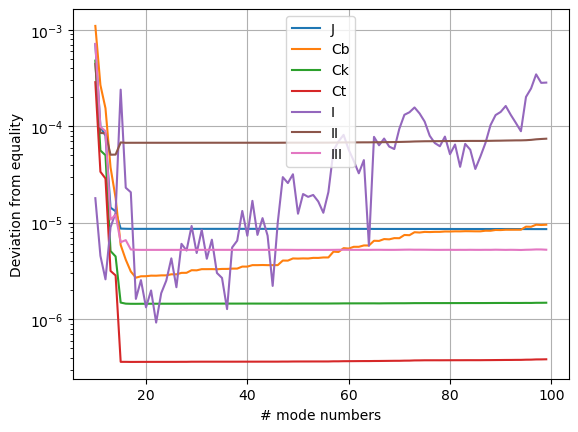

In [38]:
plot_all_errors(J_list, Cb_list, Ck_list, Ct_list, I_list, II_list, III_list)

In [43]:
param_list = list(range(10,100))
write = True
J_list=[]
Cb_list=[]
Ck_list=[]
Ct_list=[]
I_list=[]
II_list=[]
III_list=[]
time_list=[]
for i in param_list:
    start_time=time.time()
    path_i = Path('harmonic_number_5/save_test_'+str(i)+'.npz')
    if path_i.is_file():
        equilibrium = Equilibrium.load(path_i)
    else:
        equilibrium.iterate_2(
            n_eval=4,
            B_alpha_nb2=0,
            B_denom_nm1=B_denom_coef_c[3], B_denom_n=0,
            iota_new=iota_coef[1],
            loop_max_freq=(15,22)
        )
        equilibrium.iterate_2(
            B_alpha_nb2=0,
            B_denom_nm1=B_denom_coef_c[3], B_denom_n=0,
            iota_new=iota_coef[1],
            loop_max_freq=(i,10)
        )
        equilibrium.save(path_i)
    X_coef_cp = equilibrium.unknown['X_coef_cp']
    Y_coef_cp = equilibrium.unknown['Y_coef_cp']
    Z_coef_cp = equilibrium.unknown['Z_coef_cp']
    B_theta_coef_cp = equilibrium.unknown['B_theta_coef_cp']
    B_psi_coef_cp = equilibrium.unknown['B_psi_coef_cp']
    iota_coef = equilibrium.unknown['iota_coef']
    p_perp_coef_cp = equilibrium.unknown['p_perp_coef_cp']
    Delta_coef_cp = equilibrium.unknown['Delta_coef_cp']
    B_denom_coef_c = equilibrium.constant['B_denom_coef_c']
    B_alpha_coef = equilibrium.constant['B_alpha_coef']
    kap_p = equilibrium.constant['kap_p']
    dl_p = equilibrium.constant['dl_p']
    tau_p = equilibrium.constant['tau_p']
    eta = equilibrium.constant['eta']
    
    (J, Cb, Ck, Ct, I, II, III) = equilibrium.check_governing_equations(5)
    J_list.append(np.average(np.abs(J.content)))
    Cb_list.append(np.average(np.abs(Cb.content)))
    Ck_list.append(np.average(np.abs(Ck.content)))
    Ct_list.append(np.average(np.abs(Ct.content)))
    I_list.append(np.average(np.abs(I.content)))
    II_list.append(np.average(np.abs(II.content)))
    III_list.append(np.average(np.abs(III.content)))
    time_list.append(time.time() - start_time)


nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
integral_mode is simpson
nfp 1
in

For J, minimum deviation from equality occurs at max_freq: 99
For Cb, minimum deviation from equality occurs at max_freq: 25
For Ck, minimum deviation from equality occurs at max_freq: 24
For Ct, minimum deviation from equality occurs at max_freq: 22
For I, minimum deviation from equality occurs at max_freq: 35
For II, minimum deviation from equality occurs at max_freq: 19
For III, minimum deviation from equality occurs at max_freq: 30
The product of their deviation from equality is minimized at max_freq: 35


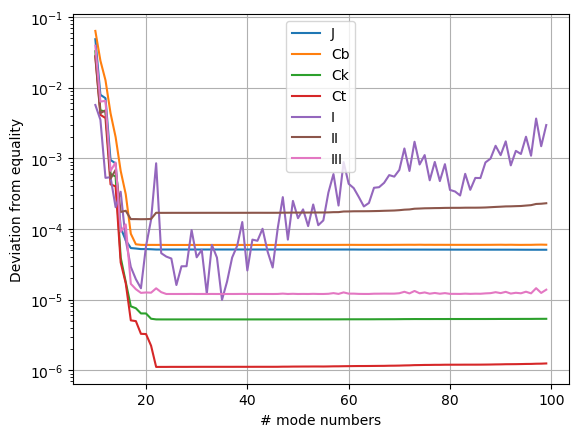

In [44]:
plot_all_errors(J_list, Cb_list, Ck_list, Ct_list, I_list, II_list, III_list)

In [45]:
# Sweeping at order 6
param_list = list(range(10,100))
write = True
J_list=[]
Cb_list=[]
Ck_lisparam_listCt_list=[]
I_list=[]
II_list=[]
III_list=[]
time_list=[]
for i in param_list:
    start_time=time.time()
    path_i = Path('harmonic_number_6/save_test_'+str(i)+'.npz')
    if path_i.is_file():
        equilibrium = Equilibrium.load(path_i)
    else:
        equilibrium.iterate_2(
            n_eval=4,
            B_alpha_nb2=0,
            B_denom_nm1=B_denom_coef_c[3], B_denom_n=0,
            iota_new=iota_coef[1],
            loop_max_freq=(15,22)
        )
        equilibrium.iterate_2(
            B_alpha_nb2=0,
            B_denom_nm1=B_denom_coef_c[3], B_denom_n=0,
            iota_new=iota_coef[1],
            loop_max_freq=(35,i)
        )
        equilibrium.save(path_i)
    X_coef_cp = equilibrium.unknown['X_coef_cp']
    Y_coef_cp = equilibrium.unknown['Y_coef_cp']
    Z_coef_cp = equilibrium.unknown['Z_coef_cp']
    B_theta_coef_cp = equilibrium.unknown['B_theta_coef_cp']
    B_psi_coef_cp = equilibrium.unknown['B_psi_coef_cp']
    iota_coef = equilibrium.unknown['iota_coef']
    p_perp_coef_cp = equilibrium.unknown['p_perp_coef_cp']
    Delta_coef_cp = equilibrium.unknown['Delta_coef_cp']
    B_denom_coef_c = equilibrium.constant['B_denom_coef_c']
    B_alpha_coef = equilibrium.constant['B_alpha_coef']
    kap_p = equilibrium.constant['kap_p']
    dl_p = equilibrium.constant['dl_p']
    tau_p = equilibrium.constant['tau_p']
    eta = equilibrium.constant['eta']
    
    (J, Cb, Ck, Ct, I, II, III) = equilibrium.check_governing_equations(6)
    J_list.append(np.average(np.abs(J.content)))
    Cb_list.append(np.average(np.abs(Cb.content)))
    Ck_list.append(np.average(np.abs(Ck.content)))
    Ct_list.append(np.average(np.abs(Ct.content)))
    I_list.append(np.average(np.abs(I.content)))
    II_list.append(np.average(np.abs(II.content)))
    III_list.append(np.average(np.abs(III.content)))
    time_list.append(time.time() - start_time)


Evaluating order 3 4
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
Time elapsed(s): 4.578288793563843
Evaluating order 5 6
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
Time elapsed(s): 9.40876293182373
Evaluating order 3 4
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
Time elapsed(s): 4.852548837661743
Evaluating order 5 6
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
Time elapsed(s): 9.918993711471558
Evaluating order 3 4
integral_mode is fft
off-diagonal filtering skipped
off-diagonal filtering skipped
integral_

For J, minimum deviation from equality occurs at max_freq: 99
For Cb, minimum deviation from equality occurs at max_freq: 24
For Ck, minimum deviation from equality occurs at max_freq: 34
For Ct, minimum deviation from equality occurs at max_freq: 36
For I, minimum deviation from equality occurs at max_freq: 38
For II, minimum deviation from equality occurs at max_freq: 30
For III, minimum deviation from equality occurs at max_freq: 96
The product of their deviation from equality is minimized at max_freq: 38


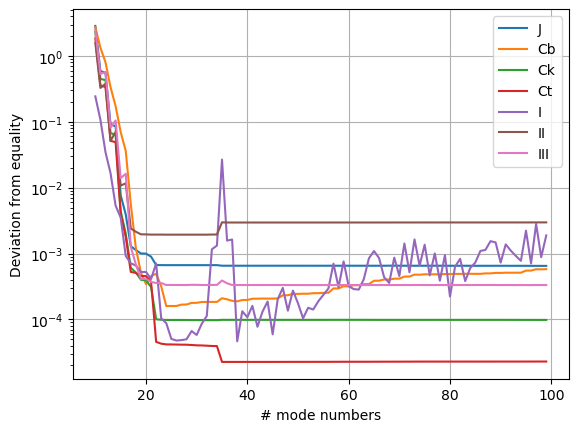

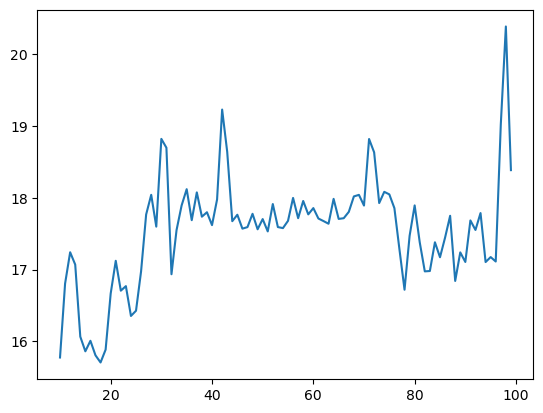

In [46]:
plot_all_errors(J_list, Cb_list, Ck_list, Ct_list, I_list, II_list, III_list)
plt.show()
plt.plot(param_list, time_list)

In [1]:
equilibrium.unknown['X_coef_cp'][6].display()

NameError: name 'equilibrium' is not defined

## Accuracy with different off-diagonal components left in before inversion

### Low pass filter not applied

In [12]:
max_k_diff_pre_inv_list = [2,3,4,5,10,15,20,25,30,40,50,100]
J_list=[]
Cb_list=[]
Ck_list=[]
Ct_list=[]
I_list=[]
II_list=[]
III_list=[]
for i in max_k_diff_pre_inv_list:
    equilibrium.iterate_2(
        n_eval=4,
        B_alpha_nb2=0,
        B_denom_nm1=B_denom_coef_c[3], B_denom_n=0,
        iota_new=iota_coef[1],
        loop_max_freq=(500,500),
        max_k_diff_pre_inv=(i,1000)
    )
    n=4
    X_coef_cp = equilibrium.unknown['X_coef_cp']
    Y_coef_cp = equilibrium.unknown['Y_coef_cp']
    Z_coef_cp = equilibrium.unknown['Z_coef_cp']
    B_theta_coef_cp = equilibrium.unknown['B_theta_coef_cp']
    B_psi_coef_cp = equilibrium.unknown['B_psi_coef_cp']
    iota_coef = equilibrium.unknown['iota_coef']
    p_perp_coef_cp = equilibrium.unknown['p_perp_coef_cp']
    Delta_coef_cp = equilibrium.unknown['Delta_coef_cp']
    B_denom_coef_c = equilibrium.constant['B_denom_coef_c']
    B_alpha_coef = equilibrium.constant['B_alpha_coef']
    kap_p = equilibrium.constant['kap_p']
    dl_p = equilibrium.constant['dl_p']
    tau_p = equilibrium.constant['tau_p']
    eta = equilibrium.constant['eta']

    J = MHD_parsed.validate_J(n,
        X_coef_cp,
        Y_coef_cp, 
        Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        kap_p, dl_p, tau_p, iota_coef)
    J_list.append(np.average(np.abs(J.content)))
    Cb = MHD_parsed.validate_Cb(n-1,
        X_coef_cp,
        Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Cb_list.append(np.average(np.abs(Cb.content)))
    Ck = MHD_parsed.validate_Ck(n-1, X_coef_cp, Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Ck_list.append(np.average(np.abs(Ck.content)))
    Ct = MHD_parsed.validate_Ct(n-1, X_coef_cp, Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Ct_list.append(np.average(np.abs(Ct.content)))
    I = MHD_parsed.validate_I(n, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp,
        iota_coef)
    I_list.append(np.average(np.abs(I.content)))
    # II 4 not satisfied.
    II = MHD_parsed.validate_II(n,
        B_theta_coef_cp, B_alpha_coef, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp, iota_coef)
    II_list.append(np.average(np.abs(II.content)))
    III = MHD_parsed.validate_III(n-2,
        B_theta_coef_cp, B_psi_coef_cp,
        B_alpha_coef, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp,
        iota_coef)
    III_list.append(np.average(np.abs(III.content)))


Evaluating order 3 4
integral_mode is fft
(4, 4, 1000, 1000)
(4, 1000, 4, 1000)
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
integral_mode is fft
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
Time elapsed(s): 65.47149109840393
Evaluating order 3 4
integral_mode is fft
(4, 4, 1000, 1000)
(4, 1000, 4, 1000)
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
integral_mode is fft
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
Time elapsed(s): 62.31581687927246
Evaluating order 3 4
integral_mode is fft
(4, 4, 1000, 1000)
(4, 1000, 4, 1000)
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
integral_mode is fft
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
Time elapsed(s): 60.13214182853699
Evaluating order 3 4
integral_mode is fft
(4, 4, 100

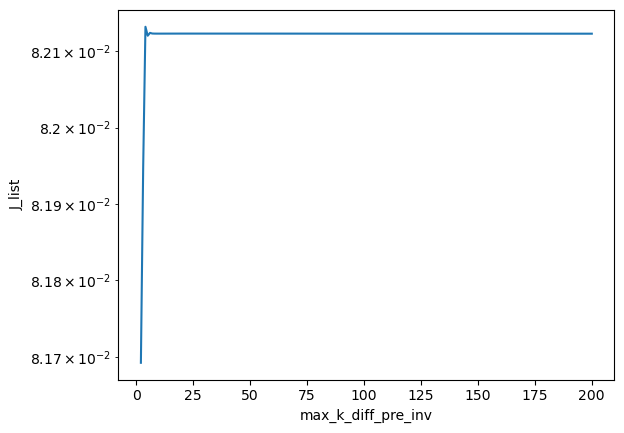

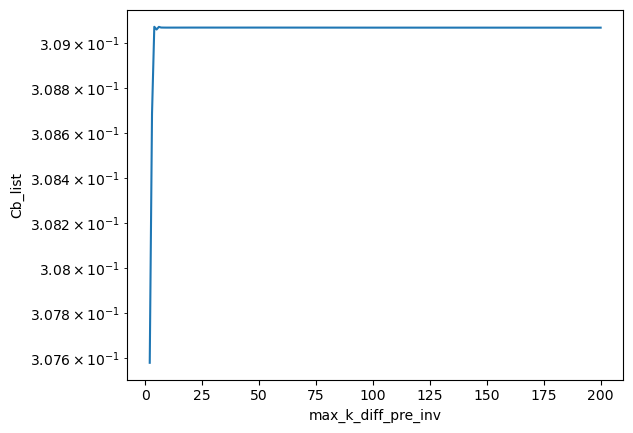

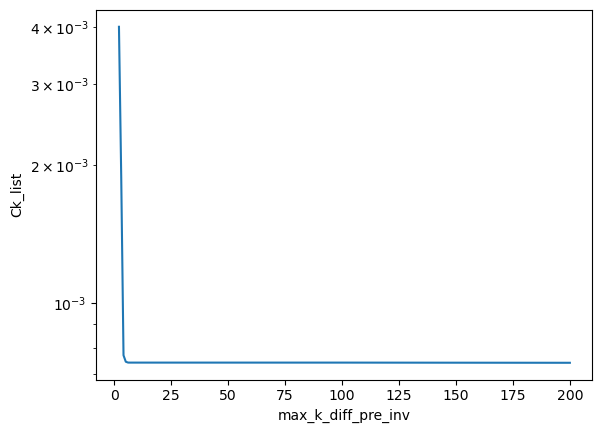

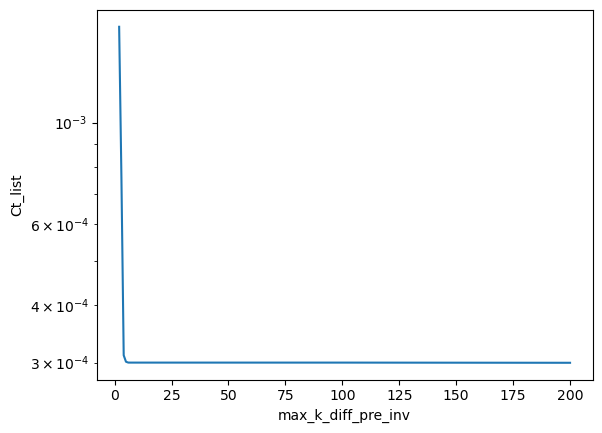

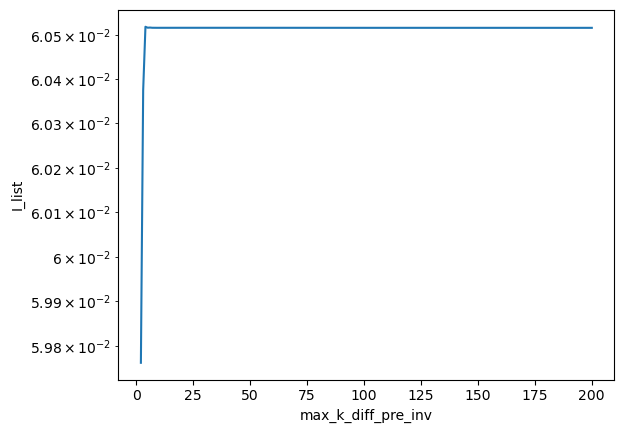

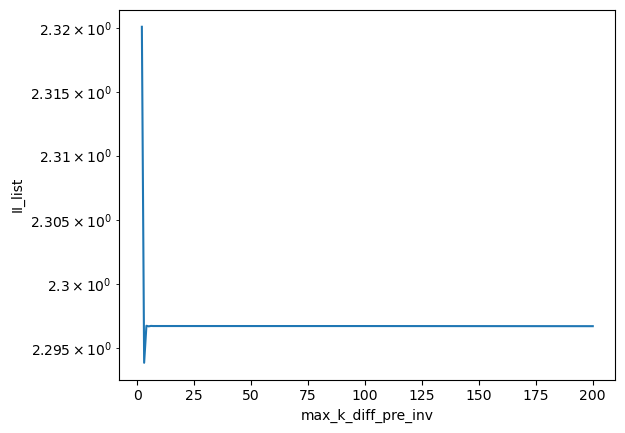

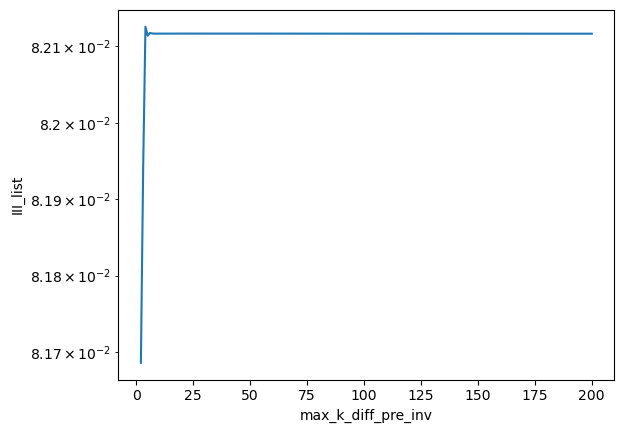

In [15]:

plt.plot(max_k_diff_pre_inv_list, J_list)
plt.yscale('log')
plt.ylabel('J_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()
plt.plot(max_k_diff_pre_inv_list, Cb_list)
plt.yscale('log')
plt.ylabel('Cb_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()
plt.plot(max_k_diff_pre_inv_list, Ck_list)
plt.yscale('log')
plt.ylabel('Ck_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()
plt.plot(max_k_diff_pre_inv_list, Ct_list)
plt.yscale('log')
plt.ylabel('Ct_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()
plt.plot(max_k_diff_pre_inv_list, I_list)
plt.yscale('log')
plt.ylabel('I_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()
plt.plot(max_k_diff_pre_inv_list, II_list)
plt.yscale('log')
plt.ylabel('II_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()
plt.plot(max_k_diff_pre_inv_list, III_list)
plt.yscale('log')
plt.ylabel('III_list')
plt.xlabel('max_k_diff_pre_inv')
plt.show()

### Low pass filter applied

In [7]:
# With filtering already applied
max_k_diff_pre_inv_list = [2,3,4,5,10,15,20,25,30,40,50,100]
J_list=[]
Cb_list=[]
Ck_list=[]
Ct_list=[]
I_list=[]
II_list=[]
III_list=[]
for i in max_k_diff_pre_inv_list:
    equilibrium.iterate_2(
        n_eval=4,
        B_alpha_nb2=0,
        B_denom_nm1=B_denom_coef_c[3], B_denom_n=0,
        iota_new=iota_coef[1],
        loop_max_freq=(20,500),
        max_k_diff_pre_inv=(i,1000)
    )
    n=4
    X_coef_cp = equilibrium.unknown['X_coef_cp']
    Y_coef_cp = equilibrium.unknown['Y_coef_cp']
    Z_coef_cp = equilibrium.unknown['Z_coef_cp']
    B_theta_coef_cp = equilibrium.unknown['B_theta_coef_cp']
    B_psi_coef_cp = equilibrium.unknown['B_psi_coef_cp']
    iota_coef = equilibrium.unknown['iota_coef']
    p_perp_coef_cp = equilibrium.unknown['p_perp_coef_cp']
    Delta_coef_cp = equilibrium.unknown['Delta_coef_cp']
    B_denom_coef_c = equilibrium.constant['B_denom_coef_c']
    B_alpha_coef = equilibrium.constant['B_alpha_coef']
    kap_p = equilibrium.constant['kap_p']
    dl_p = equilibrium.constant['dl_p']
    tau_p = equilibrium.constant['tau_p']
    eta = equilibrium.constant['eta']

    J = MHD_parsed.validate_J(n,
        X_coef_cp,
        Y_coef_cp, 
        Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        kap_p, dl_p, tau_p, iota_coef)
    J_list.append(np.average(np.abs(J.content)))
    Cb = MHD_parsed.validate_Cb(n-1,
        X_coef_cp,
        Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Cb_list.append(np.average(np.abs(Cb.content)))
    Ck = MHD_parsed.validate_Ck(n-1, X_coef_cp, Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Ck_list.append(np.average(np.abs(Ck.content)))
    Ct = MHD_parsed.validate_Ct(n-1, X_coef_cp, Y_coef_cp, Z_coef_cp,
        B_denom_coef_c, B_alpha_coef,
        B_psi_coef_cp, B_theta_coef_cp,
        kap_p, dl_p, tau_p, iota_coef)
    Ct_list.append(np.average(np.abs(Ct.content)))
    I = MHD_parsed.validate_I(n, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp,
        iota_coef)
    I_list.append(np.average(np.abs(I.content)))
    # II 4 not satisfied.
    II = MHD_parsed.validate_II(n,
        B_theta_coef_cp, B_alpha_coef, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp, iota_coef)
    II_list.append(np.average(np.abs(II.content)))
    III = MHD_parsed.validate_III(n-2,
        B_theta_coef_cp, B_psi_coef_cp,
        B_alpha_coef, B_denom_coef_c,
        p_perp_coef_cp, Delta_coef_cp,
        iota_coef)
    III_list.append(np.average(np.abs(III.content)))


Evaluating order 3 4
integral_mode is fft
(4, 4, 40, 40)
(4, 40, 4, 40)
max_k_diff 1000
len_phi 40
off-diagonal filtering skipped
integral_mode is fft
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
Time elapsed(s): 32.94901418685913
Evaluating order 3 4
integral_mode is fft
(4, 4, 40, 40)
(4, 40, 4, 40)
max_k_diff 1000
len_phi 40
off-diagonal filtering skipped
integral_mode is fft
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
Time elapsed(s): 27.98995089530945
Evaluating order 3 4
integral_mode is fft
(4, 4, 40, 40)
(4, 40, 4, 40)
max_k_diff 1000
len_phi 40
off-diagonal filtering skipped
integral_mode is fft
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
max_k_diff 1000
len_phi 1000
off-diagonal filtering skipped
Time elapsed(s): 31.828193187713623
Evaluating order 3 4
integral_mode is fft
(4, 4, 40, 40)
(4, 40, 4, 40)
max_k_dif

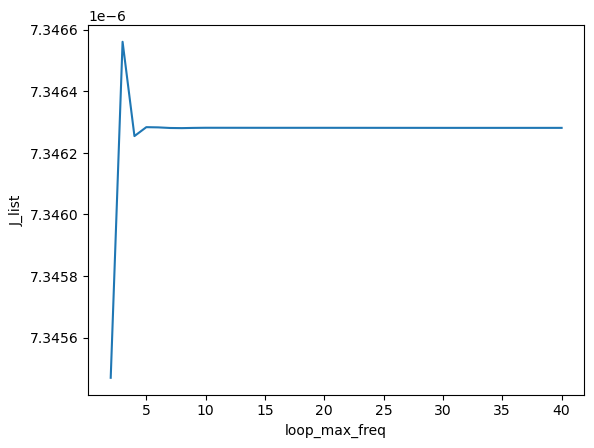

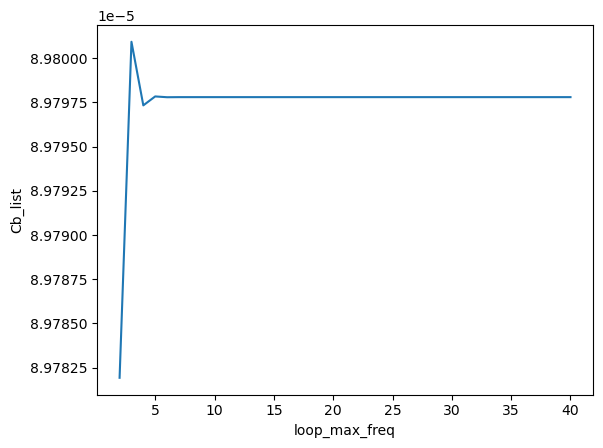

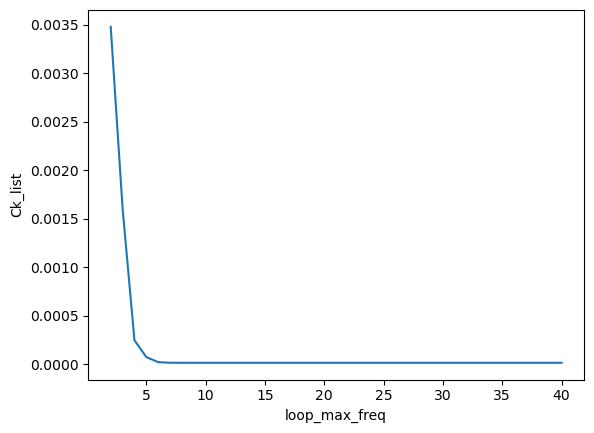

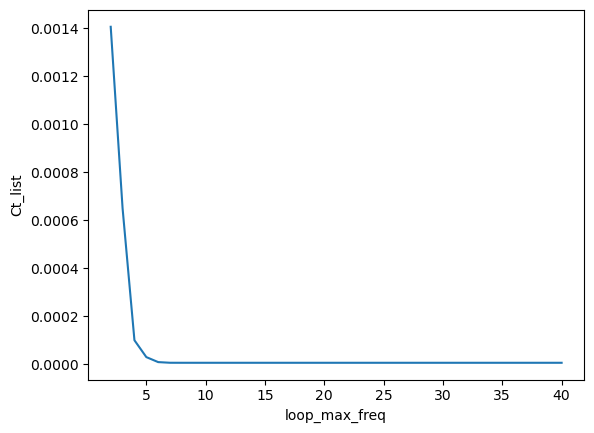

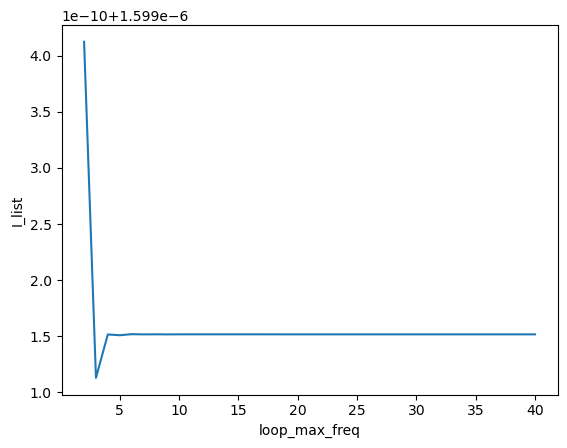

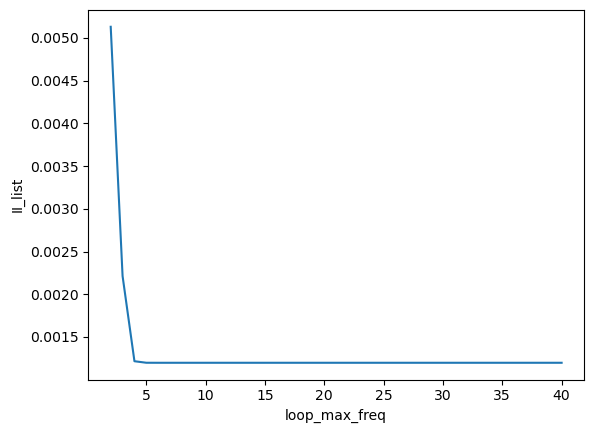

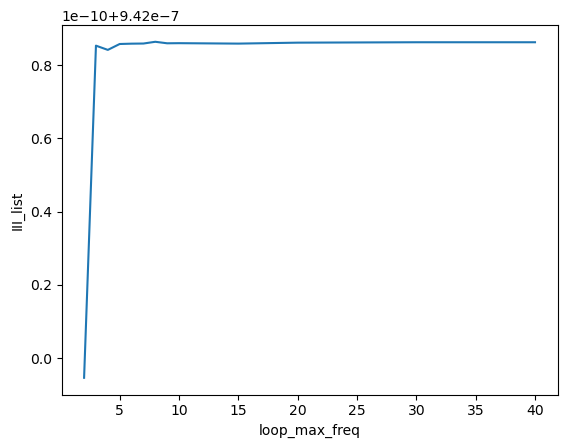

In [8]:

plt.plot(max_k_diff_pre_inv_list, J_list)
plt.ylabel('J_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()
plt.plot(max_k_diff_pre_inv_list, Cb_list)
plt.ylabel('Cb_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()
plt.plot(max_k_diff_pre_inv_list, Ck_list)
plt.ylabel('Ck_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()
plt.plot(max_k_diff_pre_inv_list, Ct_list)
plt.ylabel('Ct_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()
plt.plot(max_k_diff_pre_inv_list, I_list)
plt.ylabel('I_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()
plt.plot(max_k_diff_pre_inv_list, II_list)
plt.ylabel('II_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()
plt.plot(max_k_diff_pre_inv_list, III_list)
plt.ylabel('III_list')
plt.xlabel('max_k_diff_pre_inv_list')
plt.show()

In [17]:
a = [1,2,3,4,5,6,7,8]

In [18]:
a[:2]

[1, 2]